In [2]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from gym.wrappers import StepAPICompatibility
from collections import deque
import random
import pickle
import tqdm
import gym_utils
import gymnasium as gym
import numpy as np
import random
import collections
import time

In [3]:
# Create the environment (non-slippery version for clarity)
# Use `gym.make("FrozenLake-v8", is_slippery=True)` for the slippery version
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="ansi")

print(gym_utils.get_env_info(env))

# Close the environment (optional, good practice)
env.close()

--- Environment Info: FrozenLake-v1 ---

Observation Space: Discrete(16)
  - Type: Discrete
  - Size: 16
  - Possible Grid Shape: (4, 4)
  - Typical State Indexing (if grid):
[[ 0  1  2  3]
     [ 4  5  6  7]
     [ 8  9 10 11]
     [12 13 14 15]]

Action Space: Discrete(4)
  - Type: Discrete
  - Size: 4
  - Number of actions: 4
  - Action Mapping (FrozenLake): {0: 'Left', 1: 'Down', 2: 'Right', 3: 'Up'}

Environment Layout/Render:

SFFF
FHFH
FFFH
HFFG


Legend (FrozenLake): S=Start, F=Frozen, H=Hole, G=Goal, Highlight=Agent


In [4]:
# --- Configuration ---
ENV_NAME = "FrozenLake-v1" # Use non-slippery version for simpler model learning
# ENV_NAME = "CartPole-v1" # Alternative - requires more complex model/agent
N_EPISODES_REAL = 100    # Episodes interacting with REAL environment
N_MODEL_TRAINING_STEPS = 1000 # Total steps to train the environment model
N_AGENT_TRAINING_STEPS_MODEL = 10000 # Steps to train agent using the MODEL
BUFFER_CAPACITY = 10000  # For storing real experiences
MODEL_UPDATE_BATCH_SIZE = 32 # How many real samples to use per model update
AGENT_UPDATE_BATCH_SIZE = 32 # How many synthetic samples to use per agent update

# --- Placeholder Components ---

class SimplePolicy:
    """A basic policy (e.g., random or based on learned values)."""
    def __init__(self, action_space):
        self.action_space = action_space
        # In a real agent, this would use Q-values or policy network outputs
        self.q_table = collections.defaultdict(lambda: np.zeros(action_space.n)) # Example for Q-learning style

    def select_action(self, state, epsilon=0.1):
         # Simple epsilon-greedy for exploration
        if random.random() < epsilon:
            return self.action_space.sample()
        else:
            # Exploit: Choose best action based on current knowledge (mocked Q-table)
            if state in self.q_table:
                 return np.argmax(self.q_table[state])
            else:
                 return self.action_space.sample() # Act randomly if state is new

    def update_q_value(self, state, action, reward, next_state, done, alpha=0.1, gamma=0.99):
        """Example Q-learning update rule."""
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state]) if next_state in self.q_table else 0
        # Basic Q-learning update
        new_value = old_value + alpha * (reward + gamma * next_max * (1 - done) - old_value)
        self.q_table[state][action] = new_value

class ExperienceBuffer:
    """Stores real experiences."""
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        # Convert state to a hashable type if it's not (like numpy arrays)
        state_h = tuple(state) if isinstance(state, np.ndarray) else state
        next_state_h = tuple(next_state) if isinstance(next_state, np.ndarray) else next_state
        self.buffer.append((state_h, action, reward, next_state_h, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, len(self.buffer)))

    def __len__(self):
        return len(self.buffer)

# TODO Space wasteful because not keeping track of count but just appending new experience
class MockEnvironmentModel:
    """A very simple tabular environment model."""
    def __init__(self):
        # Stores observed transitions: {(state, action): [(next_state, reward, done), ...]}
        self.transitions = collections.defaultdict(list)
        self.observed_states = set()
        print("--- Environment Model Initialized ---")

    def train(self, state, action, reward, next_state, done):
        """'Trains' the model by storing the observed transition."""
        # Convert state to a hashable type if it's not
        state_h = tuple(state) if isinstance(state, np.ndarray) else state
        next_state_h = tuple(next_state) if isinstance(next_state, np.ndarray) else next_state
        self.transitions[(state_h, action)].append((next_state_h, reward, done))
        self.observed_states.add(state_h)
        # In a more complex scenario (e.g., CartPole), this would involve training
        # a neural network or other function approximator.

    def update_batch(self, experiences):
         """Update model using a batch of experiences."""
         print(f"    Model: Training with batch of {len(experiences)} real experiences.")
         for state, action, reward, next_state, done in experiences:
             self.train(state, action, reward, next_state, done)

    def predict(self, state, action):
        """Predicts the outcome of taking an action in a state using the learned model."""
        state_h = tuple(state) if isinstance(state, np.ndarray) else state
        if (state_h, action) in self.transitions and self.transitions[(state_h, action)]:
            # Sample from observed outcomes for this state-action pair
            next_state, reward, done = random.choice(self.transitions[(state_h, action)])
            # print(f"    Model Predict: s={state}, a={action} -> (s'={next_state}, r={reward}, d={done}) [Sampled]")
            return next_state, reward, done
        else:
            # If state-action not seen, return something neutral or raise error
            # print(f"    Model Predict: s={state}, a={action} -> Unknown transition! Returning current state.")
            return state, 0.0, False # Default guess: no change, no reward

    def sample_state_action(self):
        """Samples a state-action pair seen during model training."""
        if not self.transitions:
             return None, None # No data yet
        # Sample a state-action pair that the model has data for
        state_action_pair = random.choice(list(self.transitions.keys()))
        return state_action_pair # Returns (state, action)


# --- Workflows ---
def model_free_workflow(env_name, n_episodes):
    """Learns directly from real environment interactions."""
    print("\n=== Starting MODEL-FREE Workflow ===")
    env = gym.make(env_name)
    agent_policy = SimplePolicy(env.action_space) # Agent uses its own policy
    total_reward = 0
    print(f"Agent: Initialized (e.g., Q-Learning style)")

    for episode in range(n_episodes):
        state, info = env.reset()
        done = False
        ep_reward = 0
        step = 0
        print(f"\n--- Episode {episode + 1} ---")

        while not done:
            # 1. Select action using agent's current policy
            action = agent_policy.select_action(state)

            # 2. Interact with the REAL environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            print(f"  Step {step+1}: State={state}, Action={action} -> Real Env -> NextState={next_state}, Reward={reward}, Done={done}")

            # 3. Update the agent directly using the REAL experience
            #    (Example: Q-learning update)
            agent_policy.update_q_value(state, action, reward, next_state, done)
            # print(f"    Agent: Updated using real experience.")

            state = next_state
            ep_reward += reward
            step += 1

        total_reward += ep_reward
        print(f"Episode {episode + 1} finished. Reward: {ep_reward}")

    avg_reward = total_reward / n_episodes
    print(f"\n=== MODEL-FREE Workflow Complete ===\nAverage Reward over {n_episodes} episodes: {avg_reward:.2f}")
    env.close()
    return agent_policy # Return the learned policy/agent


def model_based_workflow(env_name, n_real_episodes, n_model_train_steps, n_agent_train_steps):
    """
    Learns a model, then uses the model to generate synthetic data
    to train the agent (using a model-free algorithm).
    """
    print("\n=== Starting MODEL-BASED Workflow ===")
    env = gym.make(env_name)
    env_model = MockEnvironmentModel()
    agent_policy = SimplePolicy(env.action_space) # Agent to be trained using the model
    real_experience_buffer = ExperienceBuffer(BUFFER_CAPACITY)
    exploration_policy = SimplePolicy(env.action_space) # Policy for gathering initial data

    # --- Phase 1: Model Learning (Interacting with Real Environment) ---
    print("\n--- Phase 1: Learning Environment Model ---")
    steps_done = 0
    episodes_done = 0
    while steps_done < n_model_train_steps:
        state, info = env.reset()
        done = False
        print(f"  Model Training Episode {episodes_done + 1} (Step {steps_done+1}/{n_model_train_steps})")
        while not done and steps_done < n_model_train_steps:
            # Use an exploratory policy to gather diverse data
            action = exploration_policy.select_action(state, epsilon=0.5) # Higher exploration

            # Interact with REAL environment
            next_state, reward, terminated, truncated, info = env.step(action)
            real_done = terminated or truncated
            # print(f"    Real Step: State={state}, Action={action} -> Real Env -> NextState={next_state}, Reward={reward}, Done={real_done}")

            # Store REAL experience
            real_experience_buffer.add(state, action, reward, next_state, real_done)

            # Periodically update the environment model using batches from buffer
            if len(real_experience_buffer) >= MODEL_UPDATE_BATCH_SIZE and steps_done % 10 == 0: # Update every 10 steps
                 experience_batch = real_experience_buffer.sample(MODEL_UPDATE_BATCH_SIZE)
                 env_model.update_batch(experience_batch)

            state = next_state
            done = real_done
            steps_done += 1
        episodes_done += 1

    print(f"\n--- Phase 1 Complete: Environment Model Trained on {steps_done} real steps ---")
    if not env_model.transitions:
         print("WARNING: Environment model has no data. Agent training might fail.")
         return None, None

    # --- Phase 2: Agent Training (Using the Learned Model) ---
    print("\n--- Phase 2: Training Agent using Learned Model ---")
    for step in range(n_agent_train_steps):
        # 1. Sample a state-action pair the model knows about
        #    (More sophisticated: sample states based on relevance or agent's policy)
        s_model, a_model = env_model.sample_state_action()

        if s_model is None: # Skip if model has no data
            if step == 0: print("    Skipping agent training step - model has no data yet."); time.sleep(1)
            continue

        # 2. Use the LEARNED environment model to predict the outcome (SYNTHETIC experience)
        next_s_model, r_model, done_model = env_model.predict(s_model, a_model)

        # 3. Update the agent (e.g., using Q-learning) with this SYNTHETIC experience
        #    Note: The *update algorithm* itself (update_q_value) is model-free!
        agent_policy.update_q_value(s_model, a_model, r_model, next_s_model, done_model)

        if step % (n_agent_train_steps // 10) == 0: # Print progress
             print(f"  Agent Training Step {step+1}/{n_agent_train_steps}: Updated agent using synthetic data (s={s_model}, a={a_model} -> s'={next_s_model}, r={r_model}, d={done_model}) from model.")

    print(f"\n--- Phase 2 Complete: Agent Trained on {n_agent_train_steps} synthetic steps ---")
    print("=== MODEL-BASED Workflow Complete ===")
    env.close()
    return agent_policy, env_model # Return learned policy and model

# --- Run Workflows ---
print(f"Using Environment: {ENV_NAME}")

# Run Model-Free
mf_policy = model_free_workflow(ENV_NAME, n_episodes=N_EPISODES_REAL)

print("\n" + "="*50 + "\n")

# Run Model-Based
mb_policy, learned_model = model_based_workflow(
    ENV_NAME,
    n_real_episodes=N_EPISODES_REAL, # Not strictly used, model training driven by steps
    n_model_train_steps=N_MODEL_TRAINING_STEPS,
    n_agent_train_steps=N_AGENT_TRAINING_STEPS_MODEL
)

# You could now compare mf_policy and mb_policy by evaluating them on the real environment

Using Environment: FrozenLake-v1

=== Starting MODEL-FREE Workflow ===
Agent: Initialized (e.g., Q-Learning style)

--- Episode 1 ---
  Step 1: State=0, Action=2 -> Real Env -> NextState=4, Reward=0.0, Done=False
  Step 2: State=4, Action=3 -> Real Env -> NextState=4, Reward=0.0, Done=False
  Step 3: State=4, Action=0 -> Real Env -> NextState=4, Reward=0.0, Done=False
  Step 4: State=4, Action=0 -> Real Env -> NextState=8, Reward=0.0, Done=False
  Step 5: State=8, Action=3 -> Real Env -> NextState=4, Reward=0.0, Done=False
  Step 6: State=4, Action=0 -> Real Env -> NextState=8, Reward=0.0, Done=False
  Step 7: State=8, Action=0 -> Real Env -> NextState=12, Reward=0.0, Done=True
Episode 1 finished. Reward: 0.0

--- Episode 2 ---
  Step 1: State=0, Action=0 -> Real Env -> NextState=0, Reward=0.0, Done=False
  Step 2: State=0, Action=0 -> Real Env -> NextState=0, Reward=0.0, Done=False
  Step 3: State=0, Action=0 -> Real Env -> NextState=0, Reward=0.0, Done=False
  Step 4: State=0, Action

In [5]:
import gymnasium as gym
import numpy as np
import random
import collections
import time

# --- Assume Components from Previous Example ---
# MockEnvironment, MockPolicy (used only for random exploration if needed)
# MockEnvironmentModel (Assume it's already trained somehow, e.g., using a buffer offline)
# We need the trained `env_model` which has a `predict(state, action)` method.

# --- Components specific to MPC ---

def evaluate_sequence(initial_state, action_sequence, env_model, gamma=0.99):
    """Simulates an action sequence using the model and calculates total discounted reward."""
    state = initial_state
    total_discounted_reward = 0.0
    discount_factor = 1.0
    # print(f"    Evaluating sequence: {action_sequence} from state {state}")
    for action in action_sequence:
        next_state, reward, done = env_model.predict(state, action)
        total_discounted_reward += discount_factor * reward
        discount_factor *= gamma
        state = next_state
        if done:
            # print(f"      Simulated 'done' after action {action}. Stopping sequence eval.")
            break # Stop simulation if model predicts termination
    # print(f"      Sequence reward: {total_discounted_reward:.3f}")
    return total_discounted_reward

def plan_actions_random_shooting(current_state, env_model, action_space, horizon=5, num_sequences=50, gamma=0.99):
    """
    Basic MPC planning: Shoot random action sequences, simulate with model, pick best first action.
    """
    best_action = None
    best_reward = -float('inf')

    # print(f"  Planning from state {current_state}: Horizon={horizon}, Sequences={num_sequences}")

    if not env_model.transitions: # Handle case where model is untrained
         print("    Model has no data, acting randomly.")
         return action_space.sample()

    for i in range(num_sequences):
        # Generate a random sequence of actions
        action_sequence = [action_space.sample() for _ in range(horizon)]

        # Evaluate this sequence using the learned model
        current_sequence_reward = evaluate_sequence(current_state, action_sequence, env_model, gamma)

        # Keep track of the best sequence found so far
        if current_sequence_reward > best_reward:
            best_reward = current_sequence_reward
            best_action = action_sequence[0] # Only care about the first action
            # print(f"    New best first action: {best_action} (Seq Reward: {best_reward:.3f})")


    # If no sequence improved reward (e.g., all led to immediate negative reward), act randomly
    if best_action is None:
        # print("    No sequence yielded positive reward / No sequences possible? Acting randomly.")
        best_action = action_space.sample()

    # print(f"  Selected action: {best_action}")
    return best_action


# --- MPC Workflow ---

def model_predictive_control_workflow(env_name, trained_env_model, n_episodes=10, horizon=5, num_sequences=50):
    """
    Uses a pre-trained model to plan at each step (MPC).
    Doesn't use a buffer for agent policy updates in the main loop.
    """
    print("\n=== Starting Model Predictive Control (MPC) Workflow ===")
    print(f"Planning Horizon={horizon}, Num Sequences={num_sequences}")

    env = gym.make(env_name, render_mode='ansi') # Or other render mode
    total_reward = 0

    if not trained_env_model or not trained_env_model.transitions:
         print("ERROR: MPC workflow requires a trained environment model!")
         # Optionally, run a quick data gathering phase here if model is empty
         # For now, we'll just exit if the model is unusable.
         # return None # Or fallback to random actions
         print("Warning: Model empty. Actions will be random.")


    for episode in range(n_episodes):
        state, info = env.reset()
        done = False
        ep_reward = 0
        step = 0
        print(f"\n--- Episode {episode + 1} ---")

        while not done:
            # 1. Plan: Use the model to find the best *first* action from the current state
            action = plan_actions_random_shooting(
                state,
                trained_env_model,
                env.action_space,
                horizon,
                num_sequences
            )

            # 2. Execute chosen action in the REAL environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            print(f"  Step {step+1}: State={state}, Planned Action={action} -> Real Env -> NextState={next_state}, Reward={reward}, Done={done}")

            # 3. Observe outcome and update state (no buffered replay for policy update)
            state = next_state
            ep_reward += reward
            step += 1

            # Optional: Update the environment model online with this new real experience
            # trained_env_model.train(previous_state, action, reward, state, done)
            # This *might* involve adding to a buffer for stable model updates,
            # but it's separate from the core decision-making loop.

        total_reward += ep_reward
        print(f"Episode {episode + 1} finished. Reward: {ep_reward}")

    avg_reward = total_reward / n_episodes
    print(f"\n=== MPC Workflow Complete ===\nAverage Reward over {n_episodes} episodes: {avg_reward:.2f}")
    env.close()


# --- Example Usage ---

# Assume `MockEnvironmentModel` class exists from previous examples

# 1. We need a trained model first. Let's quickly train one using the buffer method.
print("--- Step 0: Training a basic environment model (using buffer method) ---")
# Reusing components from the model-based example that DID use a buffer for model training
train_env = gym.make("FrozenLake-v1", is_slippery=False)
temp_buffer = ExperienceBuffer(5000)
env_model_for_mpc = MockEnvironmentModel()
steps = 0
while steps < 2000: # Gather 2000 steps of experience
    s, _ = train_env.reset()
    d = False
    while not d and steps < 2000:
        a = train_env.action_space.sample() # Explore randomly
        ns, r, term, trunc, _ = train_env.step(a)
        d = term or trunc
        temp_buffer.add(s, a, r, ns, d)
        s = ns
        steps += 1
        if steps % 200 == 0 and len(temp_buffer) >= 32:
             batch = temp_buffer.sample(32)
             env_model_for_mpc.update_batch(batch) # Train model
train_env.close()
print("--- Environment Model Training Complete ---")


# 2. Now run the MPC workflow using the trained model
model_predictive_control_workflow(
    "FrozenLake-v1",
    env_model_for_mpc,
    n_episodes=5,
    horizon=4,       # How many steps to look ahead in simulation
    num_sequences=100 # How many random plans to evaluate
)

--- Step 0: Training a basic environment model (using buffer method) ---
--- Environment Model Initialized ---
    Model: Training with batch of 32 real experiences.
    Model: Training with batch of 32 real experiences.
    Model: Training with batch of 32 real experiences.
    Model: Training with batch of 32 real experiences.
    Model: Training with batch of 32 real experiences.
    Model: Training with batch of 32 real experiences.
    Model: Training with batch of 32 real experiences.
    Model: Training with batch of 32 real experiences.
    Model: Training with batch of 32 real experiences.
    Model: Training with batch of 32 real experiences.
--- Environment Model Training Complete ---

=== Starting Model Predictive Control (MPC) Workflow ===
Planning Horizon=4, Num Sequences=100

--- Episode 1 ---
  Step 1: State=0, Planned Action=2 -> Real Env -> NextState=0, Reward=0.0, Done=False
  Step 2: State=0, Planned Action=0 -> Real Env -> NextState=0, Reward=0.0, Done=False
  Step

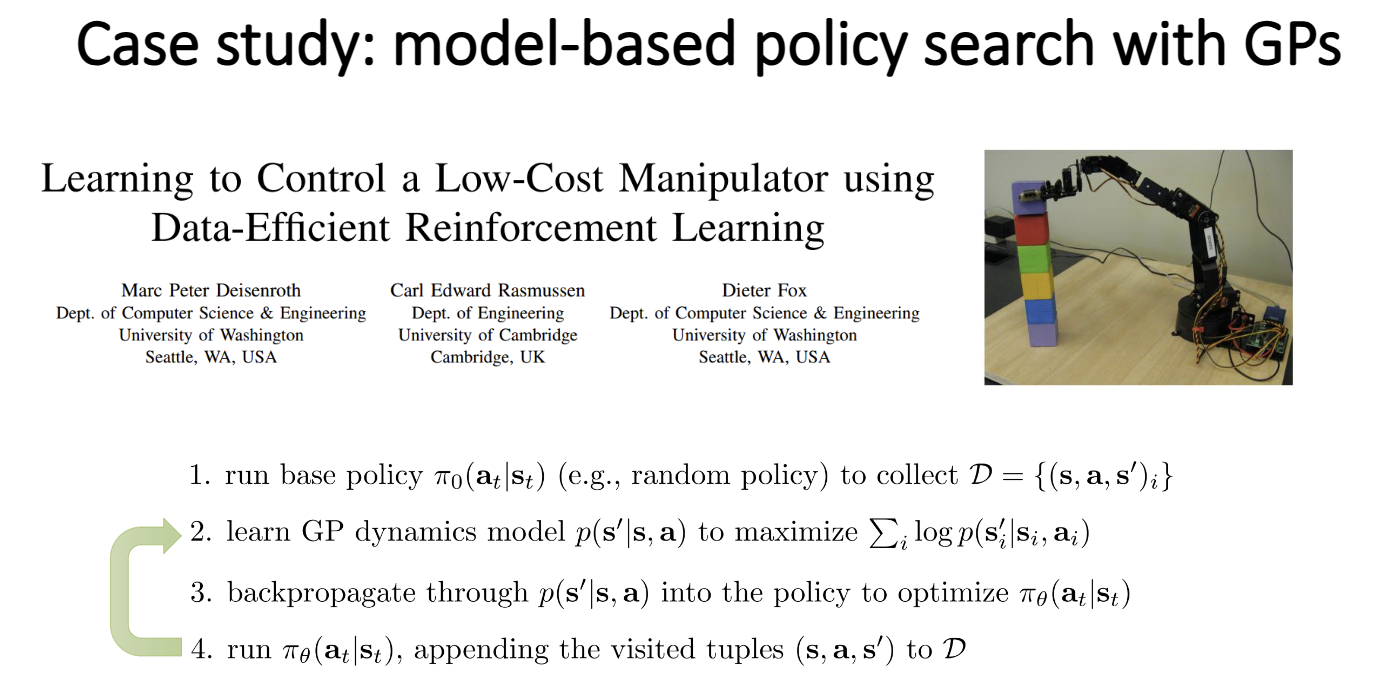

In [6]:
import numpy as np
import collections
import math

# --- Simple Count-Based Model ---
class SimpleCountModel:
    def __init__(self):
        # {(state, action): {next_state: count}}
        self.counts = collections.defaultdict(lambda: collections.defaultdict(int))
        self.totals = collections.defaultdict(int)

    def train(self, s, a, ns):
        self.counts[(s, a)][ns] += 1
        self.totals[(s, a)] += 1

    def get_probs(self, s, a):
        # Returns a dictionary {next_state: probability}
        probs = {}
        total_count = self.totals[(s, a)]
        if total_count == 0:
            return {} # Or return uniform prior, etc.
        for ns, count in self.counts[(s, a)].items():
            probs[ns] = count / total_count
        return probs

    def get_log_likelihood(self, dataset):
        # Calculates TLL = sum log p_model(s' | s, a) for (s,a,s') in dataset
        total_log_likelihood = 0.0
        tiny_val = 1e-9 # To avoid log(0)

        for s, a, actual_ns in dataset:
            # Get current model probabilities for the (s,a) pair
            current_probs = self.get_probs(s, a)

            # Get the probability assigned by the model to the actually observed next state
            prob_of_actual_ns = current_probs.get(actual_ns, 0.0)

            # Add log-probability to sum (handle case where prob is 0)
            total_log_likelihood += math.log(prob_of_actual_ns + tiny_val)

        return total_log_likelihood

# --- Simulation Parameters ---
TRUE_PROB_S0_GIVEN_S0A0 = 0.7
NUM_ITERATIONS = 30
S, A = 0, 0 # Focus on state S0, action A0

# --- Run Simulation ---
model = SimpleCountModel()
dataset = [] # Store observed transitions (s, a, s')

print("Iter | Observed NS | Total Count | Count S0 | Count S1 | p_model(S0|S0,A0) | p_model(S1|S0,A0) | Total Log Likelihood (TLL)")
print("----|---------------|-------------|----------|----------|-------------------|-------------------|-------------------------")

# Iteration 0 (Before data)
prob_s0_est, prob_s1_est = 0.0, 0.0 # Model knows nothing
tll = float('-inf') # Undefined or -infinity
print(f"{0:4d} | {'N/A':<13} | {0:11d} | {0:8d} | {0:8d} | {prob_s0_est:17.3f} | {prob_s1_est:17.3f} | {tll:23.3f}")


for i in range(1, NUM_ITERATIONS + 1):
    # 1. Simulate observing a transition from the *true* environment
    observed_ns = 0 if np.random.rand() < TRUE_PROB_S0_GIVEN_S0A0 else 1

    # 2. Add observation to dataset
    dataset.append((S, A, observed_ns))

    # 3. Train/update the model with the new observation
    model.train(S, A, observed_ns)

    # 4. Get current model state (counts and probabilities)
    current_counts = model.counts[(S, A)]
    count_s0 = current_counts.get(0, 0)
    count_s1 = current_counts.get(1, 0)
    total_count = model.totals[(S, A)]

    prob_s0_est = count_s0 / total_count if total_count > 0 else 0.0
    prob_s1_est = count_s1 / total_count if total_count > 0 else 0.0

    # 5. Calculate the TLL of the *entire dataset observed so far* using the *current* model
    tll = model.get_log_likelihood(dataset)

    print(f"{i:4d} | {observed_ns:<13d} | {total_count:11d} | {count_s0:8d} | {count_s1:8d} | {prob_s0_est:17.3f} | {prob_s1_est:17.3f} | {tll:23.3f}")

print("\n--- Final Results ---")
print(f"True Probs:      p(S0|S0,A0)={TRUE_PROB_S0_GIVEN_S0A0:.3f}, p(S1|S0,A0)={1-TRUE_PROB_S0_GIVEN_S0A0:.3f}")
print(f"Estimated Probs: p(S0|S0,A0)={prob_s0_est:.3f}, p(S1|S0,A0)={prob_s1_est:.3f}")
print(f"Final TLL: {tll:.3f}")

Iter | Observed NS | Total Count | Count S0 | Count S1 | p_model(S0|S0,A0) | p_model(S1|S0,A0) | Total Log Likelihood (TLL)
----|---------------|-------------|----------|----------|-------------------|-------------------|-------------------------
   0 | N/A           |           0 |        0 |        0 |             0.000 |             0.000 |                    -inf
   1 | 1             |           1 |        0 |        1 |             0.000 |             1.000 |                   0.000
   2 | 0             |           2 |        1 |        1 |             0.500 |             0.500 |                  -1.386
   3 | 1             |           3 |        1 |        2 |             0.333 |             0.667 |                  -1.910
   4 | 0             |           4 |        2 |        2 |             0.500 |             0.500 |                  -2.773
   5 | 1             |           5 |        2 |        3 |             0.400 |             0.600 |                  -3.365
   6 | 0       